In [2]:
# dependencies
import pandas as pd
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

from textwrap import wrap
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import math
%matplotlib inline

In [690]:
# import data
shelter_outcomes =  pd.read_csv("C:/Users/sulem/OneDrive/Desktop/machin learnign/Project3/aac_shelter_outcomes.csv")
# filter animal type for just cats
#cats = shelter_outcomes[shelter_outcomes['animal_type'] == 'Cat']
cats = shelter_outcomes
#print(cats.head())

# remove age_upon_outcome and recalculate to standard units (days)
age = cats.loc[:,['datetime', 'date_of_birth']]
# convert to datetime
age.loc[:,'datetime'] = pd.to_datetime(age['datetime'])
age.loc[:,'date_of_birth'] = pd.to_datetime(age['date_of_birth'])
# calculate cat age in days
cats.loc[:,'age'] = (age.loc[:,'datetime'] - age.loc[:,'date_of_birth']).dt.days
# get dob info
cats['dob_month'] = age.loc[:, 'date_of_birth'].dt.month
cats['dob_day'] = age.loc[:, 'date_of_birth'].dt.day
cats['dob_dayofweek'] = age.loc[:, 'date_of_birth'].dt.dayofweek
# get month from datetime
cats['month'] = age.loc[:,'datetime'].dt.month
# get day of month
cats['day'] = age.loc[:,'datetime'].dt.day
# get day of week
cats['dayofweek'] = age.loc[:, 'datetime'].dt.dayofweek
# get hour of day
cats['hour'] = age.loc[:, 'datetime'].dt.hour
# get quarter
cats['quarter'] = age.loc[:, 'datetime'].dt.quarter

# clean up breed attribute
# get breed attribute for processing
# convert to lowercase, remove mix and strip whitespace
# remove space in 'medium hair' to match 'longhair' and 'shorthair'
# split on either space or '/'
breed = cats.loc[:, 'breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip().str.split('/', expand=True)
cats['breed'] = breed[0]
cats['breed1'] = breed[1]

# clean up color attribute
# convert to lowercase
# strip spaces
# split on '/'
color = cats.loc[:, 'color'].str.lower().str.strip().str.split('/', expand=True)
cats['color'] = color[0]
cats['color1'] = color[1]

# clean up sex_upon_outcome
sex = cats['sex_upon_outcome'].str.lower().str.strip().str.split(' ', expand=True)
sex[0].replace('spayed', True, inplace=True)
sex[0].replace('neutered', True, inplace=True)
sex[0].replace('intact', False, inplace=True)
sex[1].replace(np.nan, 'unknown', inplace=True)
cats['spayed_neutered'] = sex[0]
cats['sex'] = sex[1]

# add in domesticated attribute
cats['domestic'] = np.where(cats['breed'].str.contains('domestic'), 1, 0)

# combine outcome and outcome subtype into a single attribute
cats['outcome_subtype'] = cats['outcome_subtype'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome_type'] = cats['outcome_type'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome'] = cats['outcome_type'] + '_' + cats['outcome_subtype']

# drop unnecessary columns
cats.drop(columns=['animal_id', 'name', 'age_upon_outcome', 'date_of_birth', 'datetime', 'monthyear', 'sex_upon_outcome', 'outcome_subtype', 'outcome_type'], inplace=True)
#print(cats['outcome'].value_counts())

cats.head()


,animal_type,breed,color,age,dob_month,dob_day,dob_dayofweek,month,day,dayofweek,hour,quarter,breed1,color1,spayed_neutered,sex,domestic,outcome
0,Cat,domestic shorthair,orange tabby,15,7,7,0,7,22,1,16,3,None,None,False,male,1,transfer_partner
1,Dog,beagle,white,366,11,6,1,11,7,3,11,4,None,brown,True,female,0,transfer_partner
2,Dog,pit bull,blue,429,3,31,6,6,3,1,14,2,None,white,True,male,0,adoption_unknown
3,Dog,miniature schnauzer,white,3300,6,2,3,6,15,6,15,2,None,None,True,male,0,transfer_partner
4,Other,bat,brown,181,1,7,1,7,7,0,14,3,None,None,unknown,unknown,0,euthanasia_rabies-risk


In [383]:
print("Default datatypes of shelter cat outcomes:\n")
print(cats.dtypes)

print("\nBelow is a description of the attributes in the cats dataframe:\n")

Default datatypes of shelter cat outcomes:

animal_type        object
breed              object
color              object
age                 int64
dob_month           int64
dob_day             int64
dob_dayofweek       int64
month               int64
day                 int64
dayofweek           int64
hour                int64
quarter             int64
breed1             object
color1             object
spayed_neutered    object
sex                object
domestic            int32
outcome            object
dtype: object

Below is a description of the attributes in the cats dataframe:



In [384]:
print('Below is a listing of the target classes and their distributions:')
cats['outcome'].value_counts()

Below is a listing of the target classes and their distributions:


adoption_unknown                  27186
transfer_partner                  19660
return-to-owner_unknown           14354
adoption_foster                    5558
transfer_scrp                      3211
euthanasia_suffering               2514
euthanasia_rabies-risk             2417
transfer_snr                        626
euthanasia_aggressive               506
adoption_offsite                    367
died_in-kennel                      335
disposal_unknown                    307
euthanasia_medical                  259
euthanasia_unknown                  170
died_in-foster                      164
rto-adopt_unknown                   150
euthanasia_behavior                 142
died_unknown                         87
died_enroute                         45
died_at-vet                          33
euthanasia_underage                  28
euthanasia_at-vet                    26
euthanasia_court/investigation       18
missing_in-foster                    18
relocate_unknown                     16


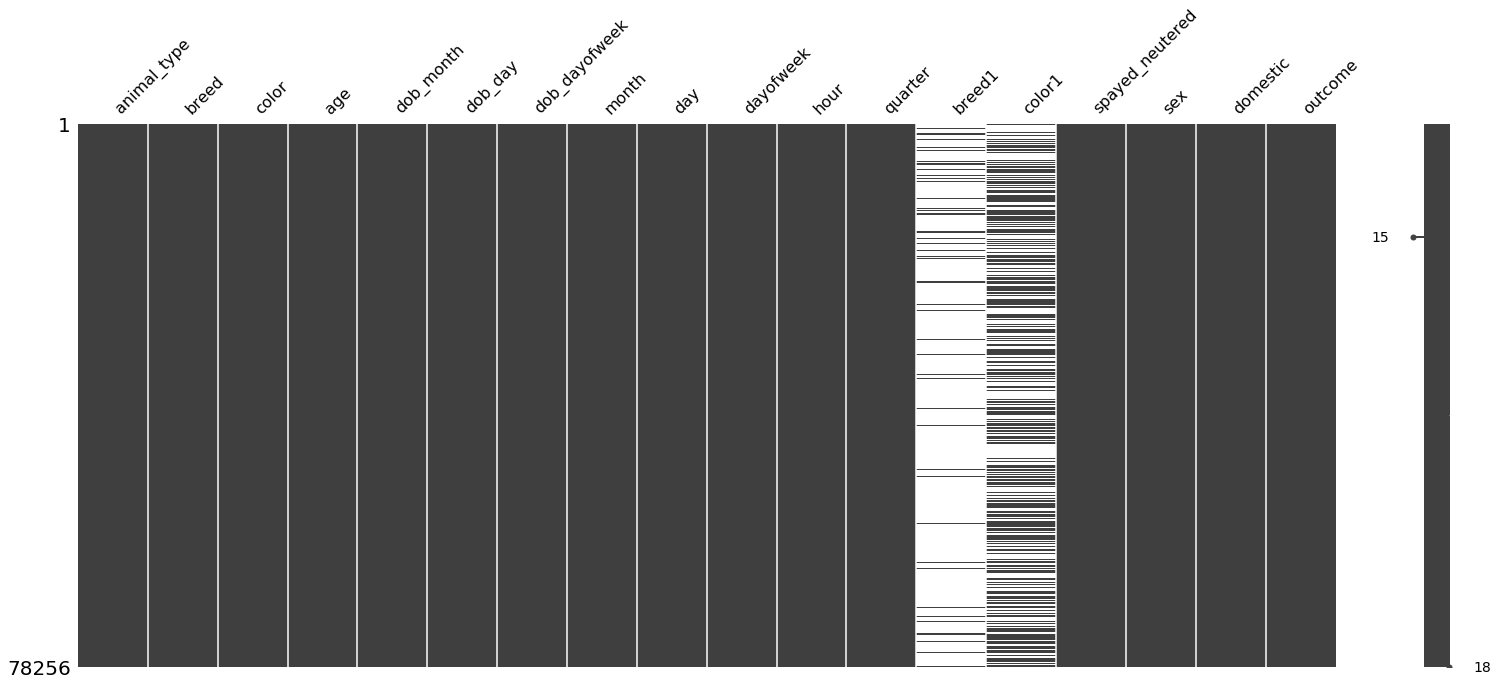

In [483]:
msno.matrix(cats )

In [691]:
cats.drop(columns=['breed1'], inplace=True)
# Breed, Color, Color1, Spayed_Netured and Sex attributes need to be one hot encoded
cats_ohe = pd.get_dummies(cats, columns=['breed', 'color', 'color1', 'spayed_neutered', 'sex','animal_type'])
cats_ohe.head()
out_t={'relocate_unknown':0,'euthanasia_court/investigation':0,'euthanasia_behavior':0,'euthanasia_suffering' : 0, 'died_in-kennel' : 0, 'return-to-owner_unknown' : 0, 'transfer_partner' : 0, 'euthanasia_at-vet' : 0, 'adoption_foster' : 1, 'died_in-foster' : 0, 'transfer_scrp' : 0, 'euthanasia_medical' : 0, 'transfer_snr' : 0, 'died_enroute' : 0, 'rto-adopt_unknown' : 1, 'missing_in-foster' : 0, 'adoption_offsite' : 1, 'adoption_unknown' :1,'euthanasia_rabies-risk' : 0, 'unknown_unknown' : 0, 'adoption_barn' : 0, 'died_unknown' : 0, 'died_in-surgery' : 0, 'euthanasia_aggressive' : 0, 'euthanasia_unknown' : 0, 'missing_unknown' : 0, 'missing_in-kennel' : 0, 'missing_possible-theft' : 0, 'died_at-vet' : 0, 'disposal_unknown' : 0, 'euthanasia_underage' : 0, 'transfer_barn' : 0}
#output is converted from string to catogries 0 to 5 represent each output
# separate outcome from data
outcome = cats_ohe['outcome']
cats_ohe.drop(columns=['outcome'])

print(cats_ohe.head())

# split the data
X_train, X_test, y_train, y_test = train_test_split(cats_ohe, outcome, test_size=0.2, random_state=0)
X_train.drop(columns=['outcome'], inplace=True)
X_test.drop(columns=['outcome'], inplace=True)
y_train = np.asarray([out_t[item] for item in y_train])
y_test = np.asarray([out_t[item] for item in y_test])
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


    age  dob_month  dob_day  dob_dayofweek  month  day  dayofweek  hour  \
0    15          7        7              0      7   22          1    16   
1   366         11        6              1     11    7          3    11   
2   429          3       31              6      6    3          1    14   
3  3300          6        2              3      6   15          6    15   
4   181          1        7              1      7    7          0    14   

   quarter  domestic        ...         spayed_neutered_True  \
0        3         1        ...                            0   
1        4         0        ...                            1   
2        2         0        ...                            1   
3        2         0        ...                            1   
4        3         0        ...                            0   

   spayed_neutered_unknown  sex_female  sex_male  sex_unknown  \
0                        0           0         1            0   
1                        0        

In [38]:
from sklearn import metrics as mt
from sklearn.preprocessing import OneHotEncoder
import keras
# from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
keras.__version__

'2.2.4'

In [338]:
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_test_ar=X_test.values
y_test_ar=np.asarray(y_test)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)

print(x_train_ar.shape)
print(y_target_ar.shape)
unique, counts = np.unique(y_target_ar, return_counts=True)
np.asarray((unique, counts))

(62604, 473)
(62604,)


array([[    0,     1],
       [35934, 26670]], dtype=int64)

In [363]:
inputs = Input(shape=(x_train_ar.shape[1],))
x = Dense(units=100, activation='relu')(inputs)
x = Dense(units=50, activation='relu')(x)

predictions = Dense(1,activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=predictions)

In [595]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 473)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 100)               47400     
_________________________________________________________________
dense_107 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 51        
Total params: 52,501
Trainable params: 52,501
Non-trainable params: 0
_________________________________________________________________


In [365]:
#%%time

model.fit(x_train_ar, y_target_ar, epochs=50, batch_size=50, verbose=0)

from sklearn import metrics as mt
yhat_proba = model.predict(x_test_ar)
yhat = np.round(yhat_proba)
#print(mt.confusion_matrix(y_test_ar,yhat),mt.accuracy_score(y_test_ar,yhat))

In [541]:
test_scores = model.evaluate(x_test_ar, y_test_ar, verbose=0)
print(mt.confusion_matrix(y_test_ar,yhat),mt.accuracy_score(y_test_ar,yhat))
test_scores


(78256, 2)

In [692]:

for i in range(78256):
 sex[0][i]=str(sex[0][i])


In [693]:
cats=cats.drop(columns=['color1'])
cats['spayed_neutered'] = sex[0]
cats=cats.dropna() 
cats

,animal_type,breed,color,age,dob_month,dob_day,dob_dayofweek,month,day,dayofweek,hour,quarter,spayed_neutered,sex,domestic,outcome
0,Cat,domestic shorthair,orange tabby,15,7,7,0,7,22,1,16,3,False,male,1,transfer_partner
1,Dog,beagle,white,366,11,6,1,11,7,3,11,4,True,female,0,transfer_partner
2,Dog,pit bull,blue,429,3,31,6,6,3,1,14,2,True,male,0,adoption_unknown
3,Dog,miniature schnauzer,white,3300,6,2,3,6,15,6,15,2,True,male,0,transfer_partner
4,Other,bat,brown,181,1,7,1,7,7,0,14,3,unknown,unknown,0,euthanasia_rabies-risk
5,Dog,leonberger,brown,126,6,3,0,10,7,0,13,4,False,male,0,transfer_partner
6,Other,squirrel,tan,365,12,13,4,12,13,5,12,4,unknown,unknown,0,euthanasia_suffering
7,Dog,chihuahua shorthair,brown,1111,11,23,2,12,8,0,15,4,True,female,0,transfer_partner
8,Cat,domestic shorthair,blue tabby,59,6,16,0,8,14,3,18,3,False,female,1,adoption_unknown
9,Cat,domestic shorthair,white,95,3,26,2,6,29,6,17,2,True,female,1,adoption_offsite


In [765]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
categorical_headers = ['animal_type','breed','color',
                       'spayed_neutered','sex']
numeric_headers = ["age", "dob_month", "dob_day","dob_dayofweek","month","day","dayofweek","hour","quarter"]
encoders = dict() 
for col in categorical_headers:
    cats[col] = cats[col].str.strip()

    encoders[col] = LabelEncoder() # save the encoder
    cats[col+'_int'] = encoders[col].fit_transform(cats[col])
for col in numeric_headers:
    cats[col] = cats[col].astype(np.float)
    
    
    ss = StandardScaler()
    cats[col] = ss.fit_transform(cats[col].values.reshape(-1, 1))


In [766]:
from sklearn.model_selection import StratifiedShuffleSplit
X_train, X_test, y_train, y_test=train_test_split(cats, outcome, test_size=0.2)

print(X_train.shape)
print(X_test.shape)


(62604, 22)
(15652, 22)


In [767]:

ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train[categorical_headers].values)
X_test_ohe = ohe.fit_transform(X_test[categorical_headers].values)

print(X_test_ohe.shape)
print(X_train_ohe.shape)

(15652, 318)
(62604, 407)


In [770]:
y_train = np.asarray([out_t[item] for item in y_train])
y_test = np.asarray([out_t[item] for item in y_test])

print(X_test_ohe.shape)
print(X_train_ohe.shape)

(15652, 318)
(62604, 407)


In [776]:
feature_columns

['animal_type_int',
 'breed_int',
 'color_int',
 'spayed_neutered_int',
 'sex_int',
 'age',
 'dob_month',
 'dob_day',
 'dob_dayofweek',
 'month',
 'day',
 'dayofweek',
 'hour',
 'quarter']

In [778]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
#   this is just to get an example running in Keras (don't ever do this)
feature_columns = categorical_headers_ints+numeric_headers
X_train_ar =  ss.fit_transform(X_train[feature_columns].values).astype(np.float32)
X_test_ar =  ss.transform(X_test[feature_columns].values).astype(np.float32)

y_train_ar = np.asarray(y_train)
y_test_ar = np.asarray(y_test)

print(feature_columns)

['animal_type_int', 'breed_int', 'color_int', 'spayed_neutered_int', 'sex_int', 'age', 'dob_month', 'dob_day', 'dob_dayofweek', 'month', 'day', 'dayofweek', 'hour', 'quarter']


In [782]:
inputs = Input(shape=(X_train_ar.shape[1],))
x = Dense(units=100, activation='relu')(inputs)
x = Dense(units=50, activation='relu')(x)

predictions = Dense(1,activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=predictions)

In [783]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 14)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 100)               1500      
_________________________________________________________________
dense_116 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 51        
Total params: 6,601
Trainable params: 6,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train_ar, y_train_ar, epochs=50, batch_size=50, verbose=0)

from sklearn import metrics as mt
yhat_proba = model.predict(X_test_ar)
yhat = np.round(yhat_proba)

In [611]:

print(mt.confusion_matrix(y_test_ar,yhat),mt.accuracy_score(y_test_ar,yhat))


[[7721 1335]
 [5196 1399]] 0.5827103699444125


In [779]:
# create sparse input branch for ohe
from keras.layers import concatenate
inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
xSparse = Dense(units=100, activation='relu', name='ohe_1')(inputsSparse)
xSparse1 = Dense(units=50, activation='relu', name='ohe_2')(xSparse)
# create dense input branch for numeric
inputsDense = Input(shape=(X_train_ar.shape[1],),sparse=False, name='X_Numeric')
xDense = Dense(units=100, activation='relu',name='num_1')(inputsDense)
xDense1 = Dense(units=50, activation='relu',name='num_2')(xDense)
x = concatenate([xSparse1, xDense1], name='concat')
predictions = Dense(1,activation='sigmoid', name='combined')(x)

# This creates a model that includes
# the Input layer and Dense layers
model = Model(inputs=[inputsSparse,inputsDense], outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_ohe (InputLayer)              (None, 407)          0                                            
__________________________________________________________________________________________________
X_Numeric (InputLayer)          (None, 14)           0                                            
__________________________________________________________________________________________________
ohe_1 (Dense)                   (None, 100)          40800       X_ohe[0][0]                      
__________________________________________________________________________________________________
num_1 (Dense)                   (None, 100)          1500        X_Numeric[0][0]                  
__________________________________________________________________________________________________
ohe_2 (Den

In [780]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit([ X_train_ohe, X_train_ar ], # inputs for each branch are a list
          y_train, 
          epochs=50, 
          batch_size=50, 
          verbose=0)


In [781]:
yhat = model.predict([X_train_ohe,
                      X_train_ar]) # each branch has an input

yhat = np.round(yhat)
print(mt.confusion_matrix(y_train_ar,yhat),mt.accuracy_score(y_train_ar,yhat))

[[29290  6662]
 [ 5890 20762]] 0.7995016292888634


In [773]:
# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = [] # keep track of inputs for each branch
X_ints_test = []# keep track of inputs for each branch
all_inputs = [] # this is what we will give to keras.Model inputs
all_branch_outputs = [] # this is where we will keep track of output of each branch

for col in categorical_headers_ints:
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs ) # keep track of created inputs
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x) 
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),sparse=False, name='numeric'))
x = Dense(units=100, activation='relu',name='numeric_1')(all_inputs[-1])
all_branch_outputs.append( Dense(units=50,activation='relu', name='numeric_2')(x) )

# merge the branches together
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
animal_type_int (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
breed_int (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
color_int (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
spayed_neutered_int (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
sex_int (I

In [775]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train + [X_train_ar], # create a list of inputs for embeddings
        y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
62604/62604 [==============================] - 5s 77us/step - loss: 0.1503 - acc: 0.7767
Epoch 2/20
62604/62604 [==============================] - 5s 72us/step - loss: 0.1491 - acc: 0.7796
Epoch 3/20
62604/62604 [==============================] - 4s 67us/step - loss: 0.1482 - acc: 0.7805
Epoch 4/20
62604/62604 [==============================] - 4s 68us/step - loss: 0.1474 - acc: 0.7821
Epoch 5/20
62604/62604 [==============================] - 4s 63us/step - loss: 0.1467 - acc: 0.7831
Epoch 6/20
62604/62604 [==============================] - 4s 66us/step - loss: 0.1461 - acc: 0.7851
Epoch 7/20
62604/62604 [==============================] - 5s 84us/step - loss: 0.1456 - acc: 0.7859
Epoch 8/20
62604/62604 [==============================] - 5s 77us/step - loss: 0.1451 - acc: 0.7867
Epoch 9/20
62604/62604 [==============================] - 5s 79us/step - loss: 0.1447 - acc: 0.7870
Epoch 10/20
62604/62604 [==============================] - 5s 82us/step - loss: 0.1443 - acc: 0.7887

In [777]:
yhat = np.round(model.predict(X_ints_test + [X_test_ar]))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[7245 1798]
 [1458 5151]] 0.791975466394071
